<a href="https://colab.research.google.com/github/noureddinekhiati/Semi-supervised-lung-segmentation/blob/main/Shape_aware_synthesis_pathological_lung_CT_scans_semi_supervised_lung_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/noureddinekhiati/Semi-supervised-lung-segmentation.git

fatal: destination path 'Semi-supervised-lung-segmentation' already exists and is not an empty directory.


In [2]:
!pip install -r /content/Semi-supervised-lung-segmentation/requirements.txt

Import Libraries

In [6]:
import os
os.chdir("/content/Semi-supervised-lung-segmentation/")

In [12]:
import torch
from model import *
from preprocess import *
import numpy as np
import cv2
from torchvision.utils import save_image
import matplotlib.pyplot as plt

Preprocess the input

In [28]:
image = cv2.imread('image_sample.png',0)
image_cropped = get_lung(image)


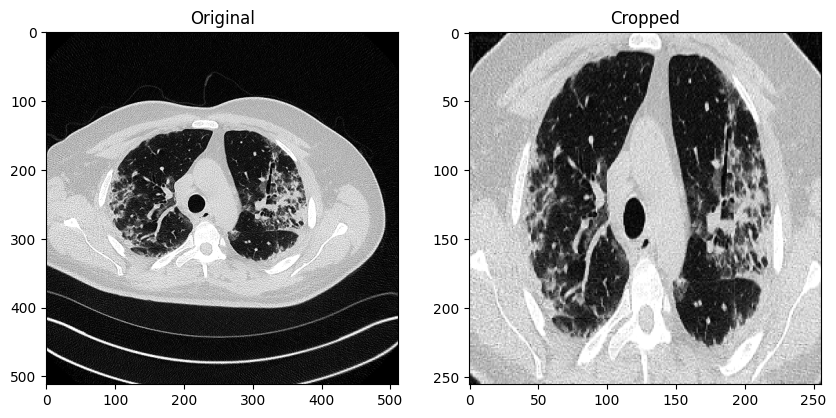

In [29]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original')

# Display the second image
axs[1].imshow(image_cropped, cmap='gray')
axs[1].set_title('Cropped')

plt.show()

Download the weights

In [3]:
# Link Drive : https://drive.google.com/file/d/1RKCohZhh5MUPG60Bga6qc33iOH1TEXbm/view?usp=sharing
!gdown --id 1RKCohZhh5MUPG60Bga6qc33iOH1TEXbm

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1RKCohZhh5MUPG60Bga6qc33iOH1TEXbm
From (redirected): https://drive.google.com/uc?id=1RKCohZhh5MUPG60Bga6qc33iOH1TEXbm&confirm=t&uuid=6741c609-3d94-443c-b16b-e2ee1b28f5ba
To: /content/weights_unet_segmentation_cycle.ckpt
100% 248M/248M [00:03<00:00, 65.4MB/s]


Load the model

In [19]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

checkpoint_path = '/content/weights_unet_segmentation_cycle.ckpt'

model = UNET(in_channels=1, out_channels=3)

checkpoint = torch.load(checkpoint_path,map_location=DEVICE)


In [23]:
state_dict = checkpoint['state_dict']

# Adjust the keys in the state_dict
adjusted_state_dict = {k.replace('net.', ''): v for k, v in state_dict.items()}

try:
    model.load_state_dict(adjusted_state_dict)
    print("Model loaded successfully")
except RuntimeError as e:
    print("Error in loading model:", e)


Model loaded successfully


Run inference

In [34]:
model.eval()
# z-score normalization
image = (torch.tensor(image_cropped/255.,dtype=torch.float32) - 0.5) / 0.5
# adding the batch and the channel axis
image = image.unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    prediction= model(image)
    prediction = torch.softmax(prediction,dim=1)
    prediction = torch.argmax(prediction,dim=1)
    save_image(prediction.float()*100, f"prediction.png")